<a href="https://colab.research.google.com/github/oumaima61/my-machine-learning-projects/blob/master/Algorithmic_Trading_with_Keras_(using_Long_Short_Time_Memory).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

Download and Manage Financial Data 

In [ ]:
start_date=datetime.datetime(1973, 1, 1)
end_date=datetime.datetime(2011,3,31) 

In [ ]:
df = pdr.get_data_yahoo('^GSPC', start=start_date, end=end_date)
df.drop("Adj Close",axis=1,inplace=True)
print(df.tail())

                   High          Low         Open        Close      Volume
Date                                                                      
2011-03-25  1319.180054  1310.150024  1311.800049  1313.800049  4223740000
2011-03-28  1319.739990  1310.189941  1315.449951  1310.189941  3215170000
2011-03-29  1319.449951  1305.260010  1309.369995  1319.439941  3482580000
2011-03-30  1331.739990  1321.890015  1321.890015  1328.260010  3809570000
2011-03-31  1329.770020  1325.030029  1327.439941  1325.829956  3566270000


In [ ]:
start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index)) 

In [ ]:
def monthly_df(df):

    dfm=df.resample("M").mean()
    dfm=dfm[:-1] # As we said, we do not consider the month of end_date
    
    dfm["fd_cm"]=first_days[:-1]
    dfm["fd_nm"]=first_days[1:]
    dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
    dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
    dfm["quot"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])
    
    dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
    dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)
    
    dfm=dfm.iloc[24:,:] # we remove the first 24 months, since they do not have the 2-year moving average
    
    return dfm 

In [ ]:
dfm=monthly_df(df)

print(dfm.head())
print(dfm.tail())

#each month of dfm contains the moving averages of the previous 12 and 24 months (excluding the current month)
print(dfm.loc["1980-03","mv_avg_12"])
print(dfm.loc["1979-03":"1980-02","Open"])
print(dfm.loc["1979-03":"1980-02","Open"].mean()) 

                 High        Low  Open  ...  quot  mv_avg_12 mv_avg_24
Date                                    ...                           
1975-01-31  73.546817  71.442273   0.0  ...   NaN        0.0       0.0
1975-02-28  80.988421  78.892106   0.0  ...   NaN        0.0       0.0
1975-03-31  84.783500  82.723500   0.0  ...   NaN        0.0       0.0
1975-04-30  85.649999  83.705001   0.0  ...   NaN        0.0       0.0
1975-05-31  91.089047  89.058096   0.0  ...   NaN        0.0       0.0

[5 rows x 12 columns]
                   High          Low  ...    mv_avg_12    mv_avg_24
Date                                  ...                          
2010-10-31  1176.353812  1163.752848  ...  1110.157418  1006.150377
2010-11-30  1203.925717  1190.292852  ...  1118.582882  1014.194553
2010-12-31  1244.202271  1236.147267  ...  1128.018077  1027.175439
2011-01-31  1286.889008  1275.542999  ...  1138.744706  1042.247068
2011-02-28  1324.536319  1312.790527  ...  1151.730256  1059.451943

[5 

Define Functions to Compute Gross and Net Yield 

In [ ]:
def yield_gross(df,v):
    prod=(v*df["quot"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100 

In [ ]:
tax_cg=0.26
comm_bk=0.001 

In [ ]:
def separate_ones(u):
    
    u_ = np.r_[0,u,0]
    i = np.flatnonzero(u_[:-1] != u_[1:])
    v,w = i[::2],i[1::2]
    if len(v)==0:
        return np.zeros(len(u)),0
    
    n,m = len(v),len(u)
    o = np.zeros(n*m,dtype=int)

    r = np.arange(n)*m
    o[v+r] = 1

    if w[-1] == m:
        o[w[:-1]+r[:-1]] = -1
    else:
        o[w+r] -= 1

    out = o.cumsum().reshape(n,-1)
    return out,n 

In [ ]:
u=np.array([0,1,1,0,1,1,1,0,1])

In [ ]:
separate_ones(u) 

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]]), 3)

In [ ]:
def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=separate_ones(v)
    A=(w*np.array(df["quot"])+(1-w)).prod(axis=1)  # A is the product of each group of ones of 1 for df["quot"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100   

Define and Train the Two Deep Learning Models 

In [ ]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data) 

In [ ]:
def data_to_model(dfm):
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Close","Volume","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
    X=dg[[0,1,2,3,4,5,6,7]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,8))
    
    y=np.array(dg[8][window:])
    
    return X,y 

In [ ]:
window=5

X,y=data_to_model(dfm)
print(X.shape,y.shape) 

(429, 6, 8) (429,)


In [ ]:
mtest=72

X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:] 

In [ ]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model 

In [ ]:
def model_mix(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    return model 

In [ ]:
model_lstm=model_lstm(window+1,8)
print(model_lstm.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 300)            370800    
_________________________________________________________________
dropout (Dropout)            (None, 6, 300)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 791,801
Trainable params: 791,801
Non-trainable params: 0
__________________________________________________

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=25, verbose=1,\
                                                 factor=0.25, min_lr=0.00001) 

In [ ]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False) 

Epoch 1/400
15/15 [==============================] - 6s 126ms/step - loss: 0.0530 - val_loss: 0.5345
Epoch 2/400
15/15 [==============================] - 1s 48ms/step - loss: 0.0034 - val_loss: 0.0217
Epoch 3/400
15/15 [==============================] - 1s 48ms/step - loss: 0.0117 - val_loss: 0.0452
Epoch 4/400
15/15 [==============================] - 1s 46ms/step - loss: 0.0243 - val_loss: 0.0139
Epoch 5/400
15/15 [==============================] - 1s 47ms/step - loss: 0.0081 - val_loss: 0.0707
Epoch 6/400
15/15 [==============================] - 1s 47ms/step - loss: 0.0118 - val_loss: 0.0329
Epoch 7/400
15/15 [==============================] - 1s 47ms/step - loss: 0.0021 - val_loss: 0.0169
Epoch 8/400
15/15 [==============================] - 1s 46ms/step - loss: 0.0106 - val_loss: 0.0147
Epoch 9/400
15/15 [==============================] - 1s 47ms/step - loss: 0.0191 - val_loss: 0.0733
Epoch 10/400
15/15 [==============================] - 1s 46ms/step - loss: 0.0109 - val_loss: 0.027

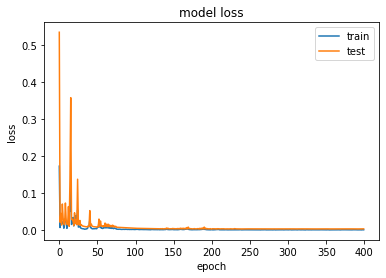

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show() 

In [ ]:
model_lstm.save_weights("lstm_weights.h5") 

In [ ]:
model_mix=model_mix(window+1,8)
print(model_mix.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             544       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 64)             4160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 300)            438000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 300)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

In [ ]:
history_mix=model_mix.fit(X_train,y_train,epochs=400, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Epoch 1/400
15/15 [==============================] - 5s 109ms/step - loss: 0.0537 - val_loss: 0.6244
Epoch 2/400
15/15 [==============================] - 1s 50ms/step - loss: 0.0082 - val_loss: 0.0722
Epoch 3/400
15/15 [==============================] - 1s 52ms/step - loss: 0.0149 - val_loss: 0.0473
Epoch 4/400
15/15 [==============================] - 1s 49ms/step - loss: 0.0508 - val_loss: 0.0119
Epoch 5/400
15/15 [==============================] - 1s 50ms/step - loss: 0.0199 - val_loss: 0.0403
Epoch 6/400
15/15 [==============================] - 1s 49ms/step - loss: 0.0130 - val_loss: 0.0654
Epoch 7/400
15/15 [==============================] - 1s 50ms/step - loss: 0.0360 - val_loss: 0.2725
Epoch 8/400
15/15 [==============================] - 1s 51ms/step - loss: 0.0032 - val_loss: 0.0123
Epoch 9/400
15/15 [==============================] - 1s 50ms/step - loss: 0.0080 - val_loss: 0.0161
Epoch 10/400
15/15 [==============================] - 1s 51ms/step - loss: 0.0055 - val_loss: 0.009

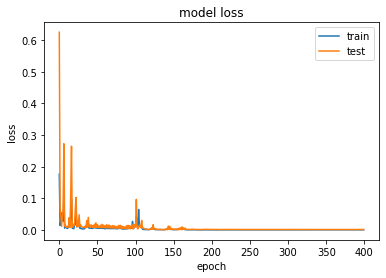

In [ ]:
plt.plot(history_mix.history['loss'])
plt.plot(history_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show() 

In [ ]:
model_mix.save_weights("mix_weights.h5") 

In [ ]:
y_pred_train_lstm=model_lstm.predict(X_train)
y_pred_train_mix=model_mix.predict(X_train)

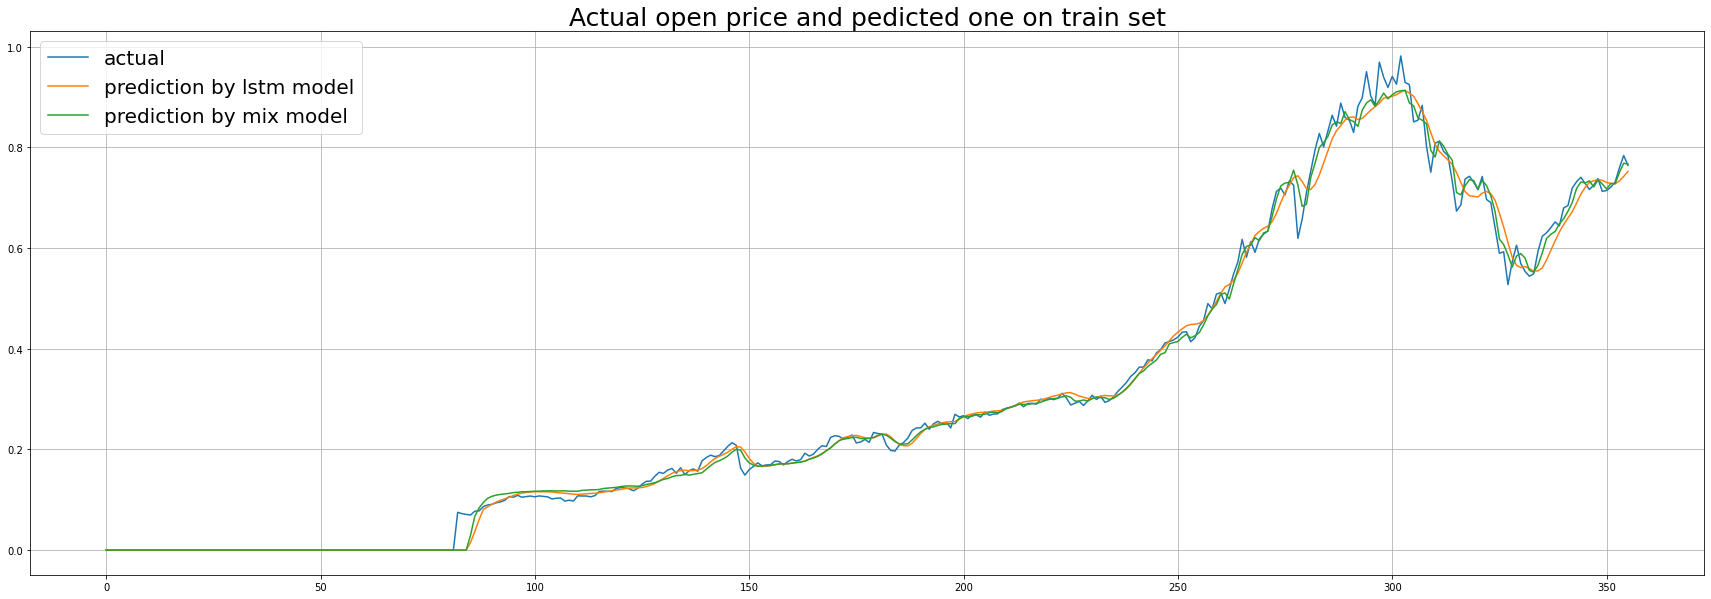

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label="actual")
plt.plot(y_pred_train_lstm, label="prediction by lstm model")
plt.plot(y_pred_train_mix, label="prediction by mix model")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show() 

Define a Simple Deep Learning Trading Strategy and Compare It with Other Ones

In [ ]:
y_pred_lstm=model_lstm.predict(X_test)
y_pred_mix=model_mix.predict(X_test) 

In [ ]:
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

w_mix=np.diff(y_pred_mix.reshape(y_pred_mix.shape[0]),1)
v_mix=np.maximum(np.sign(w_mix),0) 

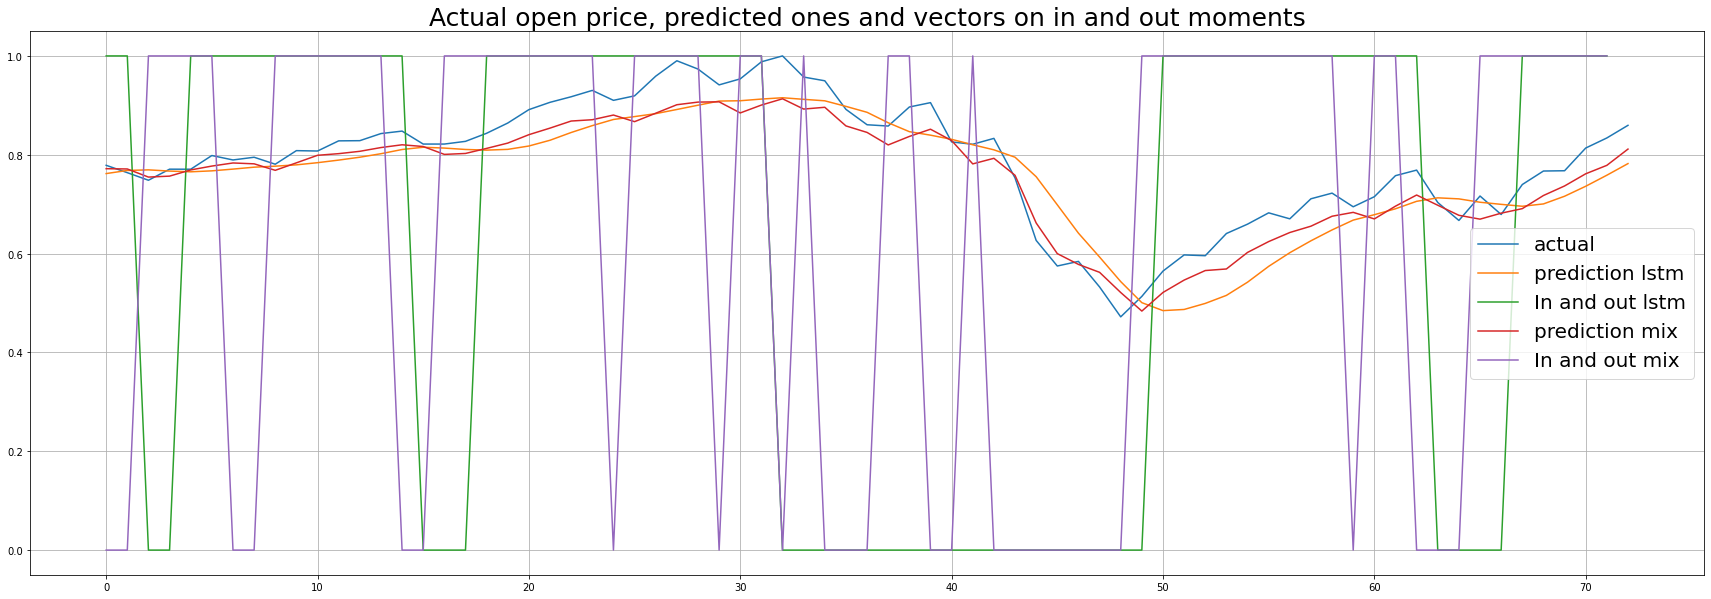

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(y_test, label="actual")
plt.plot(y_pred_lstm, label="prediction lstm")
plt.plot(v_lstm,label="In and out lstm")
plt.plot(y_pred_mix, label="prediction mix")
plt.plot(v_mix,label="In and out mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted ones and vectors on in and out moments",fontsize=25)
plt.show() 

In [ ]:
test=dfm.iloc[-mtest:,:] 
v_bh=np.ones(test.shape[0])
v_ma=test["fd_cm_open"]>test["mv_avg_12"] 

In [ ]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["quot"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio 

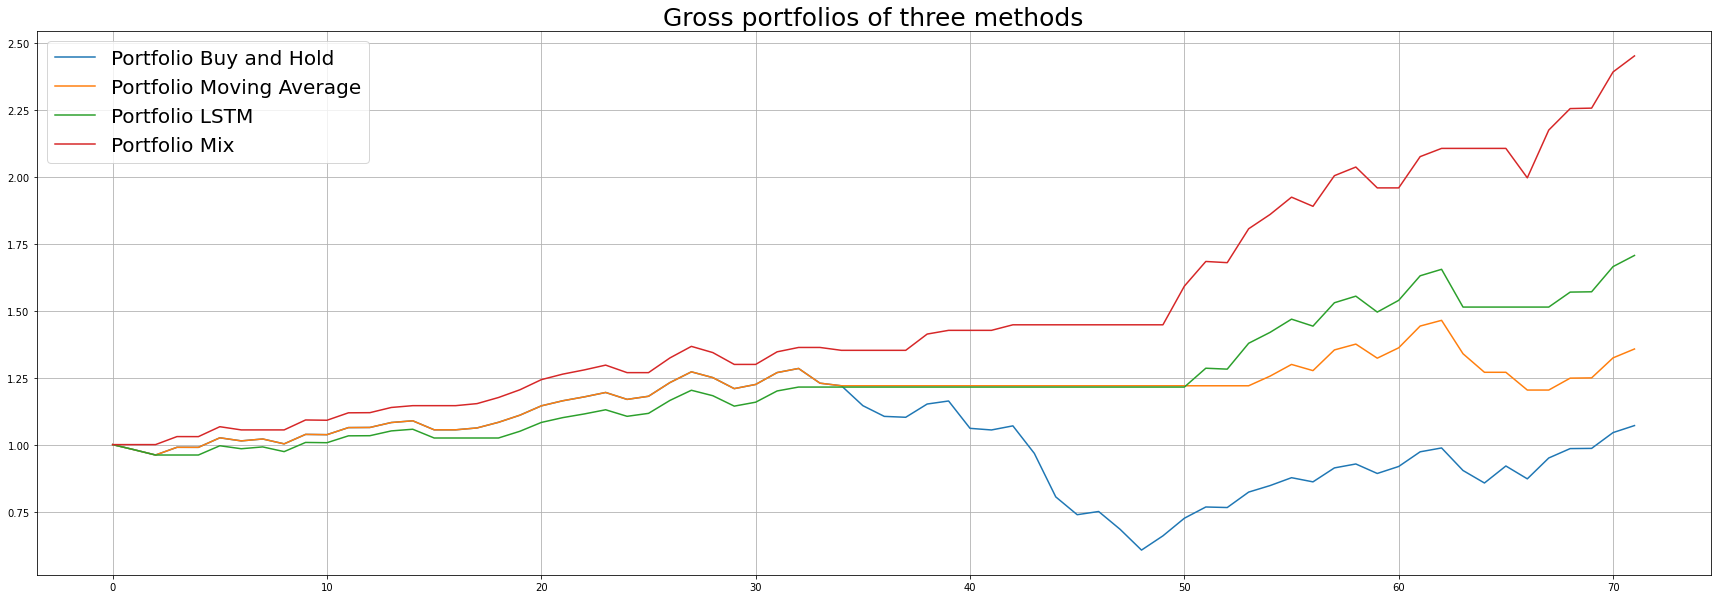

In [ ]:
plt.figure(figsize=(30,10)) 
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.plot(gross_portfolio(test,v_mix),label="Portfolio Mix")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [ ]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/12,str(test.loc[test.index[0],"fd_cm"])[:10],\
      str(test.loc[test.index[-1],"fd_nm"])[:10]))

results=pd.DataFrame({})
results["Method"]=["Buy and hold","Moving average","LSTM","Mix"]

vs=[v_bh,v_ma,v_lstm,v_mix]
results["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]
results["Total net yield"]=[str(round(yield_net(test,vi)[0],2))+" %" for vi in vs]
results["Annual net yield"]=[str(round(yield_net(test,vi)[1],2))+" %" for vi in vs]
 
print(results)

Test period of 6.00 years, from 2005-03-01 to 2011-03-01 

           Method Total gross yield  ... Total net yield Annual net yield
0    Buy and hold           10.39 %  ...          7.47 %           1.21 %
1  Moving average           39.86 %  ...         26.14 %           3.95 %
2            LSTM           75.86 %  ...         50.25 %           7.02 %
3             Mix          152.64 %  ...         96.64 %          11.93 %

[4 rows x 5 columns]
